In [1]:
# import packages
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import sklearn.datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use("ggplot")



# read data
uk_data_filename = "ar-2010-2014-xlsb.csv"
data = pd.read_csv(uk_data_filename, error_bad_lines=False, sep=';', low_memory=False)
data = data[data["Type of treatment - IVF or DI"]=="IVF"]

#columns_to_keep= ['Live Birth Occurrence','Embryos (from Eggs Micro-injected) Stored For Use By Patient','Embryos Stored For Use By Patient','Embryos Transfered from Eggs Micro-injected','Embryos Transfered','Total Embryos Thawed','Embryos from Eggs Micro-injected','Eggs Micro-injected','Total Embryos Created','Eggs Mixed With Donor sperm','Eggs Mixed With Partner Sperm','Total Eggs Mixed','Fresh Eggs Stored','Fresh Eggs Collected','Eggs Thawed','Frozen Cycle','Fresh Cycle','Sperm From','Egg Source','Elective Single Embryo Transfer','PGS Treatment','PGS','PGD treatment','PGD','Specific treatment type','Type of treatment - IVF or DI','Patient acting as Surrogate','Donated embryo','Sperm Donor Age at Registration','Egg Donor Age at Registration','Type of Ovulation Induction','Stimulation used','Main Reason for Producing Embroys Storing Eggs','Cause of Infertility -  Partner Sperm Immunological factors','Causes of Infertility - Partner Sperm Motility','Cause of Infertility -  Partner Sperm Morphology','Cause of Infertility - Partner Sperm Concentration','Cause of Infertility - Female Factors','Cause of Infertility - Cervical factors','Cause of Infertility - Endometriosis','Cause of Infertility - Patient Unexplained','Cause of Infertility - Male Factor','Cause of Infertility - Ovulatory Disorder','Cause  of Infertility - Tubal disease','Type of Infertility -Couple Secondary','Type of Infertility -Couple Primary','Type of Infertility - Male Secondary','Type of Infertility - Male Primary','Type of Infertility - Female Secondary','Type of Infertility - Female Primary','Total number of live births - conceived through DI','Total number of live births - conceived through IVF','Total number of live births - conceived through IVF or DI','Total number of DI pregnancies','Total number of IVF pregnancies','Total number of previous pregnancies, Both IVF and DI','Total Number of Previous DI cycles','Total Number of Previous IVF cycles','Total Number of Previous treatments, Both IVF and DI at clinic','Total Number of Previous cycles, Both IVF and DI','Date patient started trying to become pregnant OR date of last pregnancy','Patient Age at Treatment']
columns_to_keep= ['Live Birth Occurrence','Frozen Cycle','Sperm From','Egg Source',
                            'Stimulation used','Cause of Infertility -  Partner Sperm Immunological factors','Causes of Infertility - Partner Sperm Motility','Cause of Infertility -  Partner Sperm Morphology','Cause of Infertility - Partner Sperm Concentration','Cause of Infertility - Cervical factors','Cause of Infertility - Endometriosis','Cause of Infertility - Patient Unexplained','Cause of Infertility - Male Factor','Cause of Infertility - Ovulatory Disorder','Cause  of Infertility - Tubal disease',
                            'Total number of live births - conceived through IVF or DI','Total number of previous pregnancies, Both IVF and DI','Total Number of Previous cycles, Both IVF and DI','Date patient started trying to become pregnant OR date of last pregnancy','Patient Age at Treatment']


def clean_data(data,columns_to_keep):   
    data_prep = data[columns_to_keep]
    data_prep = data_prep.fillna(0)
    data_prep.replace(["Donor",'Patient'],[1,0], inplace=True)
    data_prep.replace(["> 50",'>=5'],[60,6], inplace=True)
    for col in data_prep.select_dtypes(include=['object']).columns:
        data_prep[col].replace(["18 - 34",'35-37','38-39','40-42','43-44','45-50',999],[1,2,3,4,5,6,7], inplace=True)
        data_prep[col].replace(["<= 20","Between 21 and 25","Between 26 and 30","Between 31 and 35",999],[1,2,3,4,2.5],inplace=True)
        data_prep[col] = data_prep[col].astype(int,errors='ignore')
    
    # One-hot encode the data using pandas get_dummies
    data_prep = pd.get_dummies(data_prep)
   
    return data_prep
data_prep = clean_data(data,columns_to_keep)
#data_prep = data_prep[data_prep['Patient Age at Treatment']!=999]

data_prep.head()

,Live Birth Occurrence,Frozen Cycle,Egg Source,Stimulation used,Cause of Infertility - Partner Sperm Immunological factors,Causes of Infertility - Partner Sperm Motility,Cause of Infertility - Partner Sperm Morphology,Cause of Infertility - Partner Sperm Concentration,Cause of Infertility - Cervical factors,Cause of Infertility - Endometriosis,...,Cause of Infertility - Tubal disease,Total number of live births - conceived through IVF or DI,"Total number of previous pregnancies, Both IVF and DI","Total Number of Previous cycles, Both IVF and DI",Date patient started trying to become pregnant OR date of last pregnancy,Patient Age at Treatment,Sperm From_1,Sperm From_Partner,Sperm From_Partner & Donor,Sperm From_not assigned
8214,0.0,1.0,0,0,0,0,0,0,0,0,...,1,1,1,3,0.0,3,0,1,0,0
8215,0.0,1.0,0,0,0,0,0,0,0,0,...,0,0,1,2,0.0,1,0,1,0,0
8216,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,3,0.0,1,0,1,0,0
8217,0.0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0.0,999,0,1,0,0
8218,0.0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0.0,1,0,1,0,0


In [135]:
data_prep.columns

Index([u'Live Birth Occurrence', u'Frozen Cycle', u'Stimulation used',
       u'Cause of Infertility -  Partner Sperm Immunological factors',
       u'Causes of Infertility - Partner Sperm Motility',
       u'Cause of Infertility -  Partner Sperm Morphology',
       u'Cause of Infertility - Partner Sperm Concentration',
       u'Cause of Infertility - Cervical factors',
       u'Cause of Infertility - Endometriosis',
       u'Cause of Infertility - Patient Unexplained',
       u'Cause of Infertility - Male Factor',
       u'Cause of Infertility - Ovulatory Disorder',
       u'Cause  of Infertility - Tubal disease',
       u'Total number of live births - conceived through IVF or DI',
       u'Total number of previous pregnancies, Both IVF and DI',
       u'Total Number of Previous cycles, Both IVF and DI',
       u'Date patient started trying to become pregnant OR date of last pregnancy',
       u'Patient Age at Treatment', u'Sperm From_Donor', u'Sperm From_Partner',
       u'Sperm From

In [46]:
def prepare_train_and_test(data_prep,random_state,test_size):
    
    #create labels and features
    labels = np.array(data_prep[u'Live Birth Occurrence'])
    features= data_prep.drop(u'Live Birth Occurrence', axis = 1)
    feature_list = list(features.columns)
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_size, random_state = random_state)

    return train_features, test_features, train_labels, test_labels, feature_list

def run_grid_algorithm(train_features, test_features, train_labels, test_labels):

    DM_train = xgb.DMatrix(data = train_features, 
                       label = train_labels,missing=999)  
    DM_test =  xgb.DMatrix(data = test_features,
                       label = test_labels,missing=999)
    
    grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [ 0.8, 1.0],
        'max_depth': [3, 5,7,10],
        'n_estimators': [100]
        }
    
    model = xgb.XGBClassifier(objective= "binary:logistic")
    
    grid_mse = GridSearchCV(estimator = model, param_grid = grid, scoring = 'roc_auc', cv = 3, verbose = 1)
    
    grid_mse.fit(train_features, train_labels)
    print("Best parameters found: ",grid_mse.best_params_)
    print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

    pred = grid_mse.predict(test_features)

    # Probabilities for each class
    probs = grid_mse.predict_proba(test_features)[:, 1]

    #return model, rfc,rfc_predictions, rfc_probs
    return model, grid_mse,pred,probs

def run_algorithm(train_features, test_features, train_labels, test_labels):

    DM_train = xgb.DMatrix(data = train_features, 
                       label = train_labels,missing=999)  
    DM_test =  xgb.DMatrix(data = test_features,
                       label = test_labels,missing=999)

    grid_mse = xgb.XGBClassifier(objective= "binary:logistic",
                            colsample_bytree= 0.8,
                            n_estimators=100,
                            max_depth=7,
                            min_child_weight= 10,
                            learning_rate= 0.01,
                            subsample= 1,
                            gamma= 1.5
                           )
    
    #grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'roc_auc', cv = 5, verbose = 1)
    
    grid_mse.fit(train_features, train_labels)
    #print("Best parameters found: ",grid_mse.best_params_)
    #print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

    pred = grid_mse.predict(test_features)

    # Probabilities for each class
    probs = grid_mse.predict_proba(test_features)[:, 1]

    #return model, rfc,rfc_predictions, rfc_probs
    return grid_mse,pred,probs

def get_numerical_feature_importance(model):

    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    matrix_feature_importance = pd.DataFrame(
    {'feature_list': feature_list,
     'importances': importances,
    })
    matrix_feature_importance.to_csv('matrix_important_features.csv')
    matrix_feature_importance = matrix_feature_importance.sort_values(by=['importances'],ascending=False)
    return matrix_feature_importance

def roc_value_algo(data_prep):
    train_features, test_features, train_labels, test_labels, feature_list = prepare_train_and_test(data_prep,random_state,test_size)
    model, rfc,rfc_predictions, rfc_probs = run_algorithm(train_features, test_features, train_labels, test_labels)
    #matrix_feature_importance = get_numerical_feature_importance(model,feature)
    roc_value = roc_auc_score(test_labels, rfc_probs)
    print(roc_value)
    
    return roc_value


In [48]:
performance_by_x_axis = []
random_state= 1000
test_size = 0.2

train_features, test_features, train_labels, test_labels, feature_list = prepare_train_and_test(data_prep,random_state,test_size)
model,pred,probs = run_algorithm(train_features, test_features, train_labels, test_labels)
matrix_feature_importance = get_numerical_feature_importance(model)
roc_value = roc_auc_score(test_labels, probs)
print(roc_value)
matrix_feature_importance

0.6262993913884902


,feature_list,importances
15,"Total Number of Previous cycles, Both IVF and DI",0.153743
16,Date patient started trying to become pregnant...,0.148248
17,Patient Age at Treatment,0.110845
14,"Total number of previous pregnancies, Both IVF...",0.084849
10,Cause of Infertility - Male Factor,0.062814
9,Cause of Infertility - Patient Unexplained,0.053777
0,Frozen Cycle,0.053358
11,Cause of Infertility - Ovulatory Disorder,0.050653
13,Total number of live births - conceived throug...,0.049509
12,Cause of Infertility - Tubal disease,0.046190


,cycle,success_rate,cumulative_success_rate
0,1,0.265113,0.265113
1,2,0.252714,0.450829
2,3,0.252672,0.589589
3,4,0.254321,0.693965


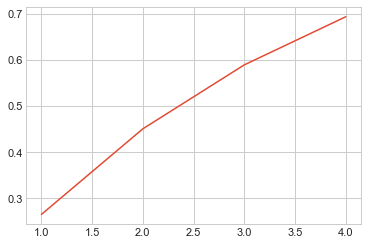

In [49]:
# calculator
courbe = pd.DataFrame(columns=['cycle',"success_rate"])
# parameters
patient_age= 0
number_pregnancies_IVF_DI= 0
number_births_IVF_DI= 0
start_date_or_last_pregnancy = 1
frozen_cycle = 0 # 1 or 0
stimulation_used = 1 # 1 or 0
infertility_sperm_immunological_factors= 0 # 1 or 0
infertility_partner_sperm_motility= 0
infertility_partner_sperm_morphology= 0
infertility_partener_sperm_concentration= 0
infertility_cervical_factors= 0 # 1 or 0
infertility_endometriosis= 0
infertility_patient_unexplained= 0
infertility_male_factor= 0
infertility_ovulatory_disorder= 0
infertility_tubal_disease= 0
sperm_from_donor= 0
sperm_from_partner= 1
sperm_from_donor_and_partner = 0
sperm_from_not_assigned= 0
egg_source = 1

for i in range(4):

    number_cycles_IVF_DI= i

    calculator= [[
        frozen_cycle, #0
        egg_source,
        stimulation_used, #1
        infertility_sperm_immunological_factors, #2
        infertility_partner_sperm_motility, #3
        infertility_partner_sperm_morphology, #4
        infertility_partener_sperm_concentration, #5
        infertility_cervical_factors, #6
        infertility_endometriosis, #7
        infertility_patient_unexplained, #8
        infertility_male_factor, #9
        infertility_ovulatory_disorder, #10
        infertility_tubal_disease, #11
        number_births_IVF_DI,  #12
        number_pregnancies_IVF_DI, #13
        number_cycles_IVF_DI, #14
        start_date_or_last_pregnancy, #15
        patient_age,    #16
        sperm_from_donor,   #17
        sperm_from_partner,  #18
        sperm_from_donor_and_partner, #19
        sperm_from_not_assigned, #20
    ]]
    courbe = courbe.append(pd.DataFrame({'cycle': [i+1], 'success_rate': [model.predict_proba(calculator)[0, 1] ]}, index=[0]), ignore_index=True)
    


#calculate cumulate rate
courbe.loc[0, 'cumulative_success_rate'] = courbe.loc[0, 'success_rate']
for i in range(1, len(courbe)):
    courbe.loc[i, 'cumulative_success_rate'] = courbe.loc[i-1, 'cumulative_success_rate']*(1-courbe.loc[i, 'success_rate']) + courbe.loc[i, 'success_rate']

y = list(courbe["cumulative_success_rate"])
x = list(courbe["cycle"])
ax = plt.plot(x, y)
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
courbe

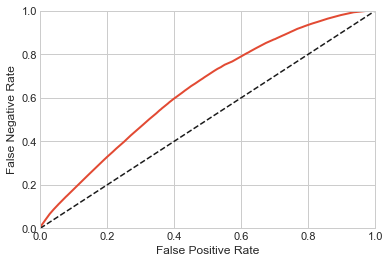

In [50]:
#plot roc curve

y_scores= model.predict_proba(train_features)
fpr, tpr, thresh= metrics.roc_curve(train_labels, y_scores[:,1])
def plot_roc_curve(fpr, tpr):

    plt.clf()
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("False Negative Rate")

plot_roc_curve(fpr, tpr)
plt.show()


CPU times: user 86.9 ms, sys: 10.5 ms, total: 97.4 ms
Wall time: 85.3 ms


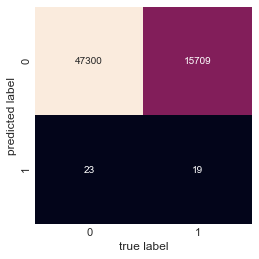

In [52]:
%%time
# plot confusion matrix
mat = confusion_matrix(test_labels, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [41]:
predictions = model.predict_proba(test_features)

predictions = pd.DataFrame(data = predictions
             , columns = ['fail_rate', 'success_rate'])
df_test_labels = pd.DataFrame(test_labels,columns = ['target'])
df_age_labels = pd.DataFrame(test_features,columns = feature_list)
finalDf = pd.concat([predictions, df_test_labels,df_age_labels], axis = 1)
finalDf.to_csv('proba_prediction.csv')
finalDf.head()

,fail_rate,success_rate,target,Frozen Cycle,Egg Source,Stimulation used,Cause of Infertility - Partner Sperm Immunological factors,Causes of Infertility - Partner Sperm Motility,Cause of Infertility - Partner Sperm Morphology,Cause of Infertility - Partner Sperm Concentration,...,Cause of Infertility - Tubal disease,Total number of live births - conceived through IVF or DI,"Total number of previous pregnancies, Both IVF and DI","Total Number of Previous cycles, Both IVF and DI",Date patient started trying to become pregnant OR date of last pregnancy,Patient Age at Treatment,Sperm From_1,Sperm From_Partner,Sperm From_Partner & Donor,Sperm From_not assigned
0,0.843125,0.156875,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,0.0,0.0
1,0.890927,0.109073,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,4.0,0.0,1.0,0.0,0.0
2,0.647288,0.352712,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.827352,0.172648,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0
4,0.639945,0.360055,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


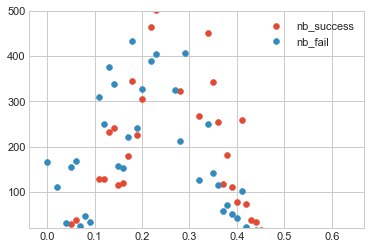

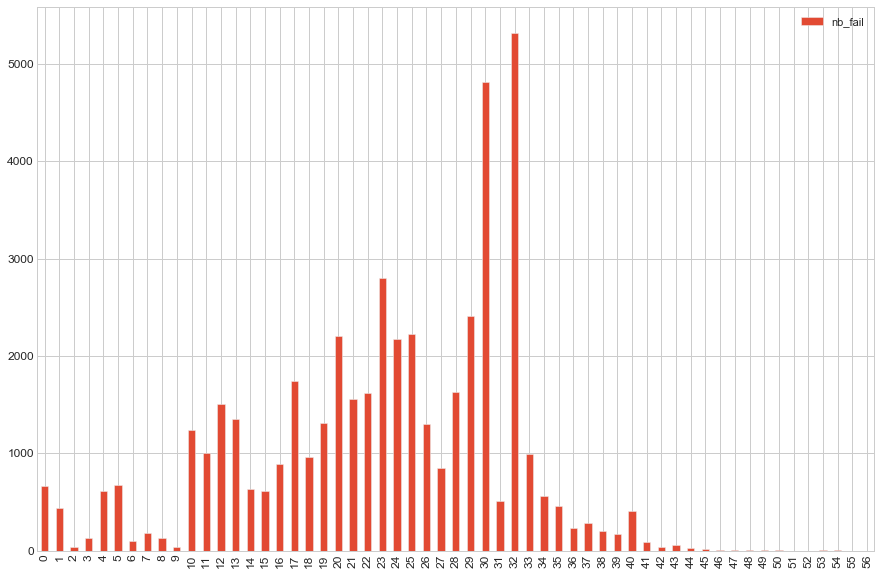

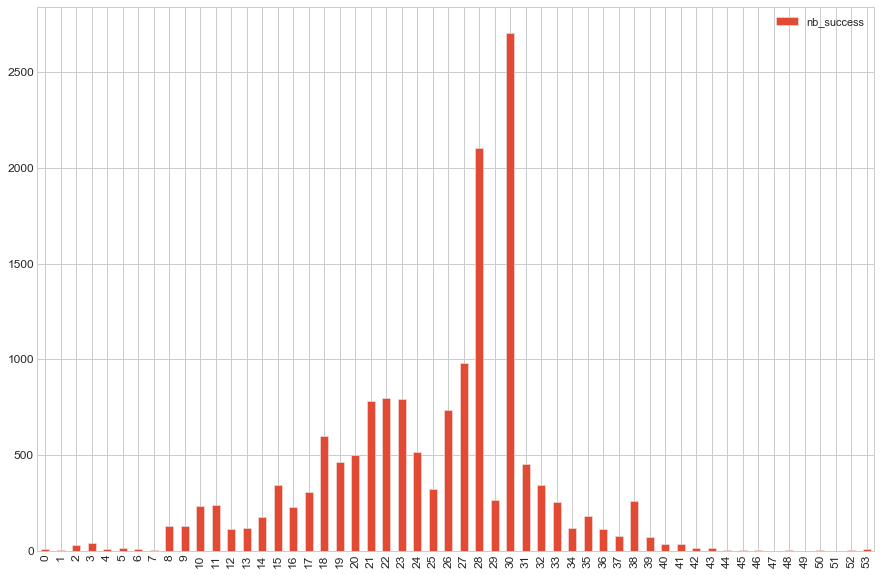

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

finalDf["success_rate"] = finalDf["success_rate"].round(2)
finalDf_ok = finalDf[finalDf["target"]==1]
finalDf_fail = finalDf[finalDf["target"]==0]
finalDf_ok = finalDf_ok.groupby(['success_rate'])["target"].agg('count').reset_index()
finalDf_fail = finalDf_fail.groupby(['success_rate'])["target"].agg('count').reset_index()
finalDf_fail.columns= ["success_rate","nb_fail"]
finalDf_ok.columns= ["success_rate","nb_success"]
x = finalDf_ok["success_rate"]
y = finalDf_ok["nb_success"]

plt.scatter(x=x, y=y,marker='o')

x = finalDf_fail["success_rate"]
y = finalDf_fail["nb_fail"]/4

plt.scatter(x=x, y=y,marker='o')
plt.legend()
plt.ylim(20, 500)

ax = finalDf_fail[['nb_fail']].plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax = finalDf_ok[['nb_success']].plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
plt.show()